In [2]:
import pandas as pd
import glob as glob

In [261]:
paths = glob.glob('../Time Series/Data/1/ToR/Numeric/*.csv')

for path in paths:
    file = pd.read_csv(path)
    file = file.reset_index().rename(columns = {'index' : 'Instante'})

    '''Create Distance between each sample for cursor position'''

    # PosA 
    posA = file[['Instante', 'PosA']]
    posA['_PosA'] = posA.PosA.shift()
    posA.loc[pd.isnull(posA._PosA), '_PosA'] = posA.loc[:1, 'PosA']
    posA['DeltaPosA'] = abs(posA['PosA'] - posA['_PosA'])
    posA['Dist_PosA'] = posA['DeltaPosA'].cumsum()

    # PosB
    posB = file[['Instante', 'PosB']]
    posB['_PosB'] = posB.PosB.shift()
    posB.loc[pd.isnull(posB._PosB), '_PosB'] = posB.loc[:1, 'PosB']
    posB['DeltaPosB'] = abs(posB['PosB'] - posB['_PosB'])
    posB['Dist_PosB'] = posB['DeltaPosB'].cumsum()

    posA = posA[['Instante', 'Dist_PosA']]
    posB = posB[['Instante', 'Dist_PosB']]

    file = file.merge(posA).merge(posB)

    '''Get RR with shift'''

    # Pulse A
    pulseA = file[file['Pulse A'] == 1]

    pulseA.loc[:, '_Instante'] = pulseA.loc[:, 'Instante'].shift()
    pulseA.loc[pd.isnull(pulseA._Instante), '_Instante'] = 0

    pulseA.loc[:, 'RR_A'] = pulseA.Instante - pulseA._Instante
    pulseA = pulseA.loc[:, ['Instante', 'PosA', 'PosB', 'RR_A', 'Dist_PosA', 'Dist_PosB']]


    # Pulse B
    pulseB = file[file['Pulse B'] == 1]

    pulseB.loc[:, '_Instante'] = pulseB.loc[:, 'Instante'].shift()
    pulseB.loc[pd.isnull(pulseB._Instante), '_Instante'] = 0

    pulseB.loc[:, 'RR_B'] = pulseB.Instante - pulseB._Instante
    pulseB = pulseB.loc[:, ['Instante', 'PosA', 'PosB', 'RR_B', 'Dist_PosA', 'Dist_PosB']]

    rr = pulseA.merge(pulseB, on = 'Instante', how = 'outer').sort_values(by = ['Instante']).reset_index(drop = True)

    '''Select the best Position'''

    rr['PosA'] = rr.apply(lambda row : row.PosA_x if pd.isnull(row.PosA_y) else row.PosA_y, axis = 1)
    rr['PosB'] = rr.apply(lambda row : row.PosB_x if pd.isnull(row.PosB_y) else row.PosB_y, axis = 1)

    rr['Dist_PosA'] = rr.apply(lambda row : row.Dist_PosA_x if pd.isnull(row.Dist_PosA_y) else row.Dist_PosA_y, axis = 1)
    rr['Dist_PosB'] = rr.apply(lambda row : row.Dist_PosB_x if pd.isnull(row.Dist_PosB_y) else row.Dist_PosB_y, axis = 1)

    rr = rr[['Instante', 'RR_A', 'RR_B', 'PosA', 'PosB', 'Dist_PosA', 'Dist_PosB']]

    # Choose left or right

    newRR = pd.DataFrame()

    for i in range(800, rr.Instante.max() + 800, 800):
        qB = rr.loc[rr.Instante < i, :].reset_index(drop = True)
        qB = qB.loc[~pd.isnull(qB.RR_B), :].reset_index(drop = True)
        b = qB.shape[0]
        qB = qB.loc[b-1:b, :]
        rrB = qB.RR_B.values[0]

        qB = rr.loc[rr.Instante < i, :].reset_index(drop = True)
        qB = qB.loc[~pd.isnull(qB.RR_B), :].reset_index(drop = True)
        B = qB.shape[0]
        qB = qB.loc[B-1:B, :]
        rrB = qB.RR_B.values[0]
        posB = qB.PosB.values[0]
        distPosB = qB.Dist_PosB.values[0]

        qA = rr.loc[rr.Instante < i, :].reset_index(drop = True)
        qA = qA.loc[~pd.isnull(qA.RR_A), :].reset_index(drop = True)
        A = qA.shape[0]
        qA = qA.loc[A-1:A, :]
        rrA = qA.RR_A.values[0]
        posA = qA.PosA.values[0]
        distPosA = qB.Dist_PosA.values[0]

        newRR = newRR.append({'Instante' : i, 'RR_A' : rrA, 'RR_B' : rrB, 'Pos_A' : posA, 'Pos_B' : posB, 'Dist_PosA' : distPosA, 'Dist_PosB' : distPosB}, ignore_index = True)

    newRR = newRR[['Instante', 'RR_A', 'RR_B', 'Pos_A', 'Pos_B', 'Dist_PosA', 'Dist_PosB']]

    '''Deal with distance'''

    newRR.loc[:, '_Dist_PosA'] = newRR.loc[:, 'Dist_PosA'].shift()
    newRR.loc[:, '_Dist_PosB'] = newRR.loc[:, 'Dist_PosB'].shift()

    newRR.loc[pd.isnull(newRR._Dist_PosA), '_Dist_PosA'] = 0
    newRR.loc[pd.isnull(newRR._Dist_PosB), '_Dist_PosB'] = 0

    newRR['Delta_PosA'] = newRR['Dist_PosA'] - newRR['_Dist_PosA']
    newRR['Delta_PosB'] = newRR['Dist_PosB'] - newRR['_Dist_PosB']

    newRR = newRR[['Instante', 'RR_A', 'RR_B', 'Pos_A', 'Pos_B', 'Delta_PosA', 'Delta_PosB']]

    '''Rename and outputs'''

    expN = int(path.split('\\')[1].split('.')[0])

    renameDict = {1 : ['A', 'B'], 2 : ['A', 'B'], 
                  3 : ['C', 'D'], 4 : ['C', 'D'],
                  5 : ['E', 'F'], 6 : ['E', 'F']}

    sufix1 = renameDict[expN][0]
    sufix2 = renameDict[expN][1]

    columns = ['Instante',
               f'RR_{sufix1}' , f'RR_{sufix2}' ,
               f'Pos_{sufix1}', f'Pos_{sufix2}', 
               f'Delta_Pos{sufix1}', f'Delta_Pos{sufix2}']

    newRR.columns = columns
    
    newRR['Instante'] = newRR.Instante.shift()
    newRR = newRR.loc[1:, :]

    newRR.to_csv(f"../Data/Processed/{expN}.csv", index = None)

<ipython-input-261-238d57ad7fd5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posA['_PosA'] = posA.PosA.shift()
C:\Users\LucasMarquesGasparin\Anaconda3\envs\assetHealth\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-261-238d57ad7fd5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

<ipython-input-261-238d57ad7fd5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posA['_PosA'] = posA.PosA.shift()
C:\Users\LucasMarquesGasparin\Anaconda3\envs\assetHealth\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-261-238d57ad7fd5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

<ipython-input-261-238d57ad7fd5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posA['_PosA'] = posA.PosA.shift()
C:\Users\LucasMarquesGasparin\Anaconda3\envs\assetHealth\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-261-238d57ad7fd5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [37]:
paths = glob.glob('../Time Series/Data/1/ToR/Numeric/*.csv')

todosRR = pd.Series()
rrs = pd.DataFrame()

for path in paths:
    file = pd.read_csv(path)
    file = file.reset_index().rename(columns = {'index' : 'Instante'})

    '''Create Distance between each sample for cursor position'''

    # PosA 
    posA = file[['Instante', 'PosA']]
    posA['_PosA'] = posA.PosA.shift()
    posA.loc[pd.isnull(posA._PosA), '_PosA'] = posA.loc[:1, 'PosA']
    posA['DeltaPosA'] = abs(posA['PosA'] - posA['_PosA'])
    posA['Dist_PosA'] = posA['DeltaPosA'].cumsum()

    # PosB
    posB = file[['Instante', 'PosB']]
    posB['_PosB'] = posB.PosB.shift()
    posB.loc[pd.isnull(posB._PosB), '_PosB'] = posB.loc[:1, 'PosB']
    posB['DeltaPosB'] = abs(posB['PosB'] - posB['_PosB'])
    posB['Dist_PosB'] = posB['DeltaPosB'].cumsum()

    posA = posA[['Instante', 'Dist_PosA']]
    posB = posB[['Instante', 'Dist_PosB']]

    file = file.merge(posA).merge(posB)

    '''Get RR with shift'''

    # Pulse A
    pulseA = file[file['Pulse A'] == 1]

    pulseA.loc[:, '_Instante'] = pulseA.loc[:, 'Instante'].shift()
    pulseA.loc[pd.isnull(pulseA._Instante), '_Instante'] = 0

    pulseA.loc[:, 'RR_A'] = pulseA.Instante - pulseA._Instante
    pulseA = pulseA.loc[:, ['Instante', 'PosA', 'PosB', 'RR_A', 'Dist_PosA', 'Dist_PosB']]


    # Pulse B
    pulseB = file[file['Pulse B'] == 1]

    pulseB.loc[:, '_Instante'] = pulseB.loc[:, 'Instante'].shift()
    pulseB.loc[pd.isnull(pulseB._Instante), '_Instante'] = 0

    pulseB.loc[:, 'RR_B'] = pulseB.Instante - pulseB._Instante
    pulseB = pulseB.loc[:, ['Instante', 'PosA', 'PosB', 'RR_B', 'Dist_PosA', 'Dist_PosB']]

    rr = pulseA.merge(pulseB, on = 'Instante', how = 'outer').sort_values(by = ['Instante']).reset_index(drop = True)

    '''Select the best Position'''

    rr['PosA'] = rr.apply(lambda row : row.PosA_x if pd.isnull(row.PosA_y) else row.PosA_y, axis = 1)
    rr['PosB'] = rr.apply(lambda row : row.PosB_x if pd.isnull(row.PosB_y) else row.PosB_y, axis = 1)

    rr['Dist_PosA'] = rr.apply(lambda row : row.Dist_PosA_x if pd.isnull(row.Dist_PosA_y) else row.Dist_PosA_y, axis = 1)
    rr['Dist_PosB'] = rr.apply(lambda row : row.Dist_PosB_x if pd.isnull(row.Dist_PosB_y) else row.Dist_PosB_y, axis = 1)

    rr = rr[['Instante', 'RR_A', 'RR_B', 'PosA', 'PosB', 'Dist_PosA', 'Dist_PosB']]
    
    todosRR = todosRR.append(rr.RR_A).append(rr.RR_B)
    rrs = pd.concat([rrs, rr.RR_A, rr.RR_B], axis = 1)

from scipy import stats

todosRR.dropna(inplace = True)

todosRR = todosRR[todosRR >= 500]

<ipython-input-37-c2e53c9bb6bf>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  todosRR = pd.Series()
<ipython-input-37-c2e53c9bb6bf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posA['_PosA'] = posA.PosA.shift()
C:\Users\LucasMarquesGasparin\Anaconda3\envs\assetHealth\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], va

<ipython-input-37-c2e53c9bb6bf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posA['_PosA'] = posA.PosA.shift()
<ipython-input-37-c2e53c9bb6bf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posA['DeltaPosA'] = abs(posA['PosA'] - posA['_PosA'])
<ipython-input-37-c2e53c9bb6bf>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

C:\Users\LucasMarquesGasparin\Anaconda3\envs\assetHealth\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\LucasMarquesGasparin\Anaconda3\envs\assetHealth\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\LucasMarquesGasparin\Anaconda3\envs\assetHealth\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is try

In [38]:
rrs.columns = ['M-A', 'M-B', 'S-A', 'S-B', 'M-C', 'M-D', 'S-C', 'S-D', 'M-E', 'M-F', 'S-E', 'S-F']

In [39]:
for c in rrs.columns:
    rrs.loc[rrs[c] < 500, c] = None

In [56]:
todos = rrs.reset_index().merge(pd.DataFrame(todosRR).rename(columns = {0 : 'All'}).reset_index(), how = 'outer').drop(columns = ['index'])

In [62]:
stats.percentileofscore(todos.All, 800)

88.03966005665723

<AxesSubplot:>

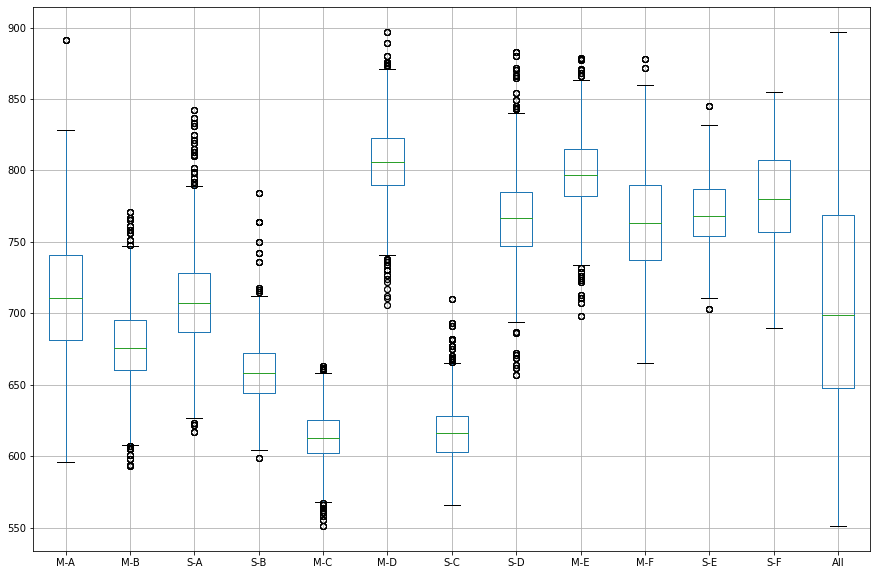

In [59]:
todos.boxplot(figsize=(15,10))

<AxesSubplot:>

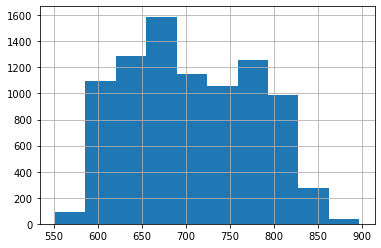

In [17]:
todosRR.hist()

In [60]:
todos.to_csv('../Data/Processed/Outros/RR_Tratado_Íntegro.csv', index = None)